In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d
import os

# Fungsi untuk memuat gambar sesuai dengan ekstensi file
def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"File tidak ditemukan: {image_path}")

    valid_extensions = ['.jpg', '.jpeg', '.png', 'webp']
    ext = os.path.splitext(image_path)[-1].lower()

    if ext not in valid_extensions:
        raise ValueError("Format file tidak didukung. Harap gunakan file dengan ekstensi .jpg, .jpeg, .png, atau .webp.")

    image = Image.open(image_path)
    return image

# Fungsi untuk mengonversi gambar ke grayscale
def convert_to_grayscale(image_np):
    if image_np.shape[2] != 3:
        raise ValueError("Gambar bukan format RGB")
    gray_image = 0.2989 * image_np[:, :, 0] + 0.5870 * image_np[:, :, 1] + 0.1140 * image_np[:, :, 2]
    return gray_image

# Kelas untuk K-Means
class KMeans:
    def __init__(self, k, seed=None):
        self.k = 3
        self.seed = seed

    def train(self, X, MAXITER=100, TOL=1e-3):
        if self.seed is not None:
            np.random.seed(self.seed)
        centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]
        centroids_old = centroids.copy()
        for iter_ in range(MAXITER):
            dist = np.linalg.norm(X - centroids[0, :], axis=1).reshape(-1, 1)
            for class_ in range(1, self.k):
                dist = np.append(dist, np.linalg.norm(X - centroids[class_, :], axis=1).reshape(-1, 1), axis=1)
            classes = np.argmin(dist, axis=1)
            for class_ in set(classes):
                centroids[class_, :] = np.mean(X[classes == class_, :], axis=0)
            if np.linalg.norm(centroids - centroids_old) < TOL:
                break
            centroids_old = centroids.copy()
        self.centroids = centroids

    def predict(self, X):
        dist = np.linalg.norm(X - self.centroids[0, :], axis=1).reshape(-1, 1)
        for class_ in range(1, self.k):
            dist = np.append(dist, np.linalg.norm(X - self.centroids[class_, :], axis=1).reshape(-1, 1), axis=1)
        classes = np.argmin(dist, axis=1)
        return classes

# Fungsi untuk melakukan clustering dengan K-Means
def perform_kmeans(gray_image, k, seed):
    pixels = gray_image.reshape(-1, 1)
    kmeans = KMeans(k, seed=seed)
    kmeans.train(pixels)
    classes = kmeans.predict(pixels)
    clustered_image = classes.reshape(gray_image.shape)
    return clustered_image, kmeans.centroids

# Fungsi untuk mendeteksi tepi Sobel secara manual
def sobel_edge_detection(image):
    # Kernel Sobel untuk deteksi tepi horizontal
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

    # Kernel Sobel untuk deteksi tepi vertikal
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Konvolusi citra dengan kernel Sobel di kedua arah
    edges_x = convolve2d(image, sobel_x, mode='same')
    edges_y = convolve2d(image, sobel_y, mode='same')

    # Menggabungkan kedua arah deteksi tepi
    edges = np.sqrt(edges_x**2 + edges_y**2)

    return edges

# Fungsi untuk menentukan hasil akhir berdasarkan clustering
def determine_result(image_np, clustered_image, kmeans_centroids):
    unique, counts = np.unique(clustered_image, return_counts=True)
    cluster_frequencies = dict(zip(unique, counts))
    dominant_cluster = max(cluster_frequencies, key=cluster_frequencies.get)

    if dominant_cluster == 1:
        result_title = 'Wajah Normal'
        result_image = image_np
    else:
        acne_cluster = np.argmin(kmeans_centroids)
        acne_mask = (clustered_image == acne_cluster).astype(np.uint8)
        result_title = 'Wajah Berjerawat'
        result_image = image_np.copy()
        result_image[acne_mask == 1] = [255, 0, 0]
    return result_image, result_title

# Fungsi untuk menampilkan gambar
def display_images(original, grayscale, clustered, sobel_edges, result, result_title):
    plt.figure(figsize=(25, 10))

    plt.subplot(1, 5, 1)
    plt.imshow(original)
    plt.axis('off')
    plt.title('Citra Asli')

    plt.subplot(1, 5, 2)
    plt.imshow(grayscale, cmap='gray')
    plt.axis('off')
    plt.title('Citra Grayscale')

    plt.subplot(1, 5, 3)
    plt.imshow(clustered, cmap='gray')
    plt.axis('off')
    plt.title('Hasil K-Means Clustering')

    plt.subplot(1, 5, 4)
    plt.imshow(sobel_edges, cmap='gray')
    plt.axis('off')
    plt.title('Deteksi Tepi Sobel')

    plt.subplot(1, 5, 5)
    plt.imshow(result)
    plt.axis('off')
    plt.title(result_title)

    plt.show()

# Fungsi untuk menampilkan citra dengan kontur tepi
def display_edges_on_image(original_image, edges_image):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Citra Asli')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original_image)
    plt.contour(edges_image, levels=[50, 100], colors='r')
    plt.title('Kontur Tepi Sobel pada Citra Asli')
    plt.axis('off')

    plt.show()

# Menampilkan citra asli dengan kontur tepi
def display_original_image_with_edges(image_path):
    # Memuat dan memproses citra
    image = load_image(image_path)
    image_np = np.array(image)
    gray_image = convert_to_grayscale(image_np)

    # K-Means Clustering dengan 2 cluster (wajah normal dan wajah berjerawat)
    clustered_image, kmeans_centroids = perform_kmeans(gray_image, k=2, seed=42)

    # Konversi citra biner dari hasil K-Means Clustering
    binary_image = np.where(clustered_image == 1, 255, 0).astype(np.uint8)

    # Deteksi tepi menggunakan metode Sobel secara manual
    edges = sobel_edge_detection(binary_image)

    # Tentukan hasil berdasarkan clustering
    result_image, result_title = determine_result(image_np, clustered_image, kmeans_centroids)

    # Menampilkan citra asli dengan kontur tepi
    display_edges_on_image(image_np, edges)

    # Menampilkan semua versi citra
    display_images(image_np, gray_image, clustered_image, edges, result_image, result_title)

# Menyesuaikan dengan path image
image_path = '/content/WajahNormal2.jpg'

# Menampilkan citra asli dengan kontur tepi
display_original_image_with_edges(image_path)


FileNotFoundError: File tidak ditemukan: /content/WajahNormal2.jpg

Gonku fiemas

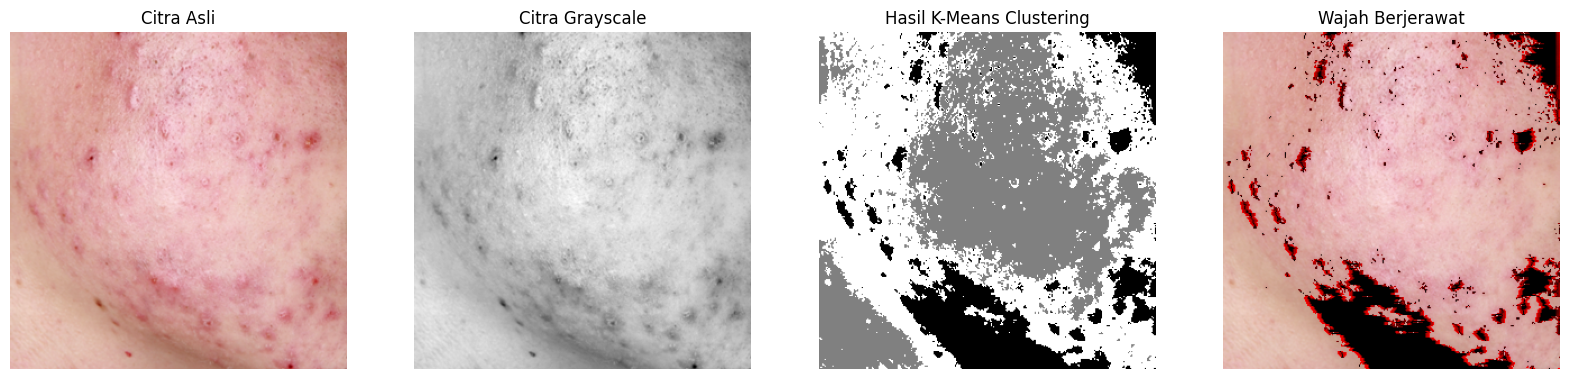

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Fungsi untuk memuat gambar sesuai dengan ekstensi file
def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"File tidak ditemukan: {image_path}")

    valid_extensions = ['.jpg', '.jpeg', '.png', 'webp']
    ext = os.path.splitext(image_path)[-1].lower()

    if ext not in valid_extensions:
        raise ValueError("Format file tidak didukung. Harap gunakan file dengan ekstensi .jpg, .jpeg, .png, atau .webp.")

    image = Image.open(image_path)
    return image

# Fungsi untuk mengonversi gambar ke grayscale
def convert_to_grayscale(image_np):
    if image_np.shape[2] != 3:
        raise ValueError("Gambar bukan format RGB")
    gray_image = 0.2989 * image_np[:, :, 0] + 0.5870 * image_np[:, :, 1] + 0.1140 * image_np[:, :, 2]
    return gray_image

# Fungsi untuk menampilkan gambar
def display_images(original, grayscale, clustered, result, result_title):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 4, 1)
    plt.imshow(original)
    plt.axis('off')
    plt.title('Citra Asli')

    plt.subplot(1, 4, 2)
    plt.imshow(grayscale, cmap='gray')
    plt.axis('off')
    plt.title('Citra Grayscale')

    plt.subplot(1, 4, 3)
    plt.imshow(clustered, cmap='gray')
    plt.axis('off')
    plt.title('Hasil K-Means Clustering')

    plt.subplot(1, 4, 4)
    plt.imshow(result)
    plt.axis('off')
    plt.title(result_title)

    plt.show()

# Kelas untuk K-Means
class KMeans:
    def __init__(self, k, seed=None):
        self.k = k
        self.seed = seed

    def train(self, X, MAXITER=100, TOL=1e-3):
        if self.seed is not None:
            np.random.seed(self.seed)
        centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]
        centroids_old = centroids.copy()
        for iter_ in range(MAXITER):
            dist = np.linalg.norm(X - centroids[0, :], axis=1).reshape(-1, 1)
            for class_ in range(1, self.k):
                dist = np.append(dist, np.linalg.norm(X - centroids[class_, :], axis=1).reshape(-1, 1), axis=1)
            classes = np.argmin(dist, axis=1)
            for class_ in set(classes):
                centroids[class_, :] = np.mean(X[classes == class_, :], axis=0)
            if np.linalg.norm(centroids - centroids_old) < TOL:
                break
            centroids_old = centroids.copy()
        self.centroids = centroids

    def predict(self, X):
        dist = np.linalg.norm(X - self.centroids[0, :], axis=1).reshape(-1, 1)
        for class_ in range(1, self.k):
            dist = np.append(dist, np.linalg.norm(X - self.centroids[class_, :], axis=1).reshape(-1, 1), axis=1)
        classes = np.argmin(dist, axis=1)
        return classes

# Fungsi untuk melakukan clustering dengan K-Means
def perform_kmeans(gray_image, k, seed):
    pixels = gray_image.reshape(-1, 1)
    kmeans = KMeans(k, seed=seed)
    kmeans.train(pixels)
    classes = kmeans.predict(pixels)
    clustered_image = classes.reshape(gray_image.shape)
    return clustered_image, kmeans.centroids

# Fungsi untuk menentukan hasil akhir berdasarkan clustering
def determine_result(image_np, clustered_image, kmeans_centroids):
    unique, counts = np.unique(clustered_image, return_counts=True)
    cluster_frequencies = dict(zip(unique, counts))
    dominant_cluster = max(cluster_frequencies, key=cluster_frequencies.get)

    if dominant_cluster == 1:
        result_title = 'Wajah Normal'
        result_image = image_np
    else:
        acne_cluster = np.argmin(kmeans_centroids)
        acne_mask = (clustered_image == acne_cluster).astype(np.uint8)
        result_title = 'Wajah Berjerawat'
        result_image = image_np.copy()
        result_image[acne_mask == 1] = [255, 0, 0]  # Mengubah piksel berjerawat menjadi warna merah

        # Deteksi tepi Sobel secara manual pada area berjerawat
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

        edges_x = np.abs(np.convolve(result_image[:, :, 0].flatten(), sobel_x.flatten(), mode='same')).reshape(result_image[:, :, 0].shape)
        edges_y = np.abs(np.convolve(result_image[:, :, 0].flatten(), sobel_y.flatten(), mode='same')).reshape(result_image[:, :, 0].shape)

        edges = edges_x + edges_y
        edges[edges > 255] = 255  # Memastikan nilai maksimal adalah 255

        # Menggabungkan tepi dengan gambar asli
        edges = edges.astype(np.uint8)
        result_image[acne_mask == 1] = [255, 0, 0]  # Mengembalikan warna merah untuk area berjerawat
        result_image[:, :, 0][acne_mask == 1] = edges[acne_mask == 1]  # Menggabungkan tepi dengan area berjerawat

    return result_image, result_title


# Menyesuaikan dengan path image
image_path = 'acne.png'

# Main execution
image = load_image(image_path)
image_np = np.array(image)
gray_image = convert_to_grayscale(image_np)
clustered_image, kmeans_centroids = perform_kmeans(gray_image, k=3, seed=42)
result_image, result_title = determine_result(image_np, clustered_image, kmeans_centroids)

display_images(image, gray_image, clustered_image, result_image, result_title)


Onok kontur e gae deteksi keparahan

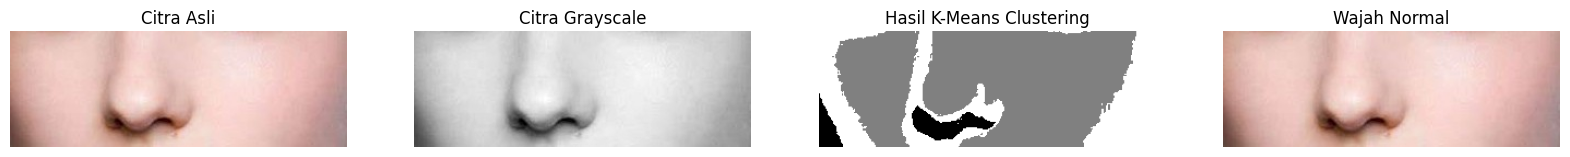

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

# Fungsi untuk memuat gambar sesuai dengan ekstensi file
def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"File tidak ditemukan: {image_path}")

    valid_extensions = ['.jpg', '.jpeg', '.png', 'webp']
    ext = os.path.splitext(image_path)[-1].lower()

    if ext not in valid_extensions:
        raise ValueError("Format file tidak didukung. Harap gunakan file dengan ekstensi .jpg, .jpeg, .png, atau .webp.")

    image = Image.open(image_path)
    return image

# Fungsi untuk mengonversi gambar ke grayscale
def convert_to_grayscale(image_np):
    if image_np.shape[2] != 3:
        raise ValueError("Gambar bukan format RGB")
    gray_image = 0.2989 * image_np[:, :, 0] + 0.5870 * image_np[:, :, 1] + 0.1140 * image_np[:, :, 2]
    return gray_image

# Fungsi untuk menampilkan gambar
def display_images(original, grayscale, clustered, result, result_title):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 4, 1)
    plt.imshow(original)
    plt.axis('off')
    plt.title('Citra Asli')

    plt.subplot(1, 4, 2)
    plt.imshow(grayscale, cmap='gray')
    plt.axis('off')
    plt.title('Citra Grayscale')

    plt.subplot(1, 4, 3)
    plt.imshow(clustered, cmap='gray')
    plt.axis('off')
    plt.title('Hasil K-Means Clustering')

    plt.subplot(1, 4, 4)
    plt.imshow(result)
    plt.axis('off')
    plt.title(result_title)

    plt.show()

# Kelas untuk K-Means
class KMeans:
    def __init__(self, k, seed=None):
        self.k = k
        self.seed = seed

    def train(self, X, MAXITER=100, TOL=1e-3):
        if self.seed is not None:
            np.random.seed(self.seed)
        centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]
        centroids_old = centroids.copy()
        for iter_ in range(MAXITER):
            dist = np.linalg.norm(X - centroids[0, :], axis=1).reshape(-1, 1)
            for class_ in range(1, self.k):
                dist = np.append(dist, np.linalg.norm(X - centroids[class_, :], axis=1).reshape(-1, 1), axis=1)
            classes = np.argmin(dist, axis=1)
            for class_ in set(classes):
                centroids[class_, :] = np.mean(X[classes == class_, :], axis=0)
            if np.linalg.norm(centroids - centroids_old) < TOL:
                break
            centroids_old = centroids.copy()
        self.centroids = centroids

    def predict(self, X):
        dist = np.linalg.norm(X - self.centroids[0, :], axis=1).reshape(-1, 1)
        for class_ in range(1, self.k):
            dist = np.append(dist, np.linalg.norm(X - self.centroids[class_, :], axis=1).reshape(-1, 1), axis=1)
        classes = np.argmin(dist, axis=1)
        return classes

# Fungsi untuk melakukan clustering dengan K-Means
def perform_kmeans(gray_image, k, seed):
    pixels = gray_image.reshape(-1, 1)
    kmeans = KMeans(k, seed=seed)
    kmeans.train(pixels)
    classes = kmeans.predict(pixels)
    clustered_image = classes.reshape(gray_image.shape)
    return clustered_image, kmeans.centroids

# Fungsi untuk menentukan hasil akhir berdasarkan clustering
def determine_result(image_np, clustered_image, kmeans_centroids):
    unique, counts = np.unique(clustered_image, return_counts=True)
    cluster_frequencies = dict(zip(unique, counts))
    dominant_cluster = max(cluster_frequencies, key=cluster_frequencies.get)

    if dominant_cluster == 1:
        result_title = 'Wajah Normal'
        result_image = image_np
    else:
        acne_cluster = np.argmin(kmeans_centroids)
        acne_mask = (clustered_image == acne_cluster).astype(np.uint8)
        result_title = 'Wajah Berjerawat'
        result_image = image_np.copy()
        result_image[acne_mask == 1] = [255, 0, 0]  # Mengubah piksel berjerawat menjadi warna merah

        # Deteksi tepi Sobel secara manual pada area berjerawat
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

        edges_x = np.abs(np.convolve(result_image[:, :, 0].flatten(), sobel_x.flatten(), mode='same')).reshape(result_image[:, :, 0].shape)
        edges_y = np.abs(np.convolve(result_image[:, :, 0].flatten(), sobel_y.flatten(), mode='same')).reshape(result_image[:, :, 0].shape)

        edges = edges_x + edges_y
        edges[edges > 255] = 255  # Memastikan nilai maksimal adalah 255

        # Menggabungkan tepi dengan gambar asli
        edges = edges.astype(np.uint8)
        result_image[acne_mask == 1] = [255, 0, 0]  # Mengembalikan warna merah untuk area berjerawat
        result_image[:, :, 0][acne_mask == 1] = edges[acne_mask == 1]  # Menggabungkan tepi dengan area berjerawat

        # Menambahkan kontur pada hasil deteksi tepi Sobel
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(result_image, contours, -1, (0, 255, 0), 2)  # Kontur berwarna hijau

        # Identifikasi tingkat keparahan jerawat berdasarkan jumlah kontur
        num_contours = len(contours)
        if num_contours >= 1 and num_contours <= 5:
            result_title = 'Wajah Berjerawat Ringan'
            print("Jumlah kontur yang berhasil dideteksi = " + str(len(contours)))
        elif num_contours > 5 and num_contours <= 10:
            result_title = 'Wajah Berjerawat Sedang'
            print("Jumlah kontur yang berhasil dideteksi = " + str(len(contours)))
        else:
            result_title = 'Wajah Berjerawat Parah'
            print("Jumlah kontur yang berhasil dideteksi = " + str(len(contours)))

    return result_image, result_title


# Menyesuaikan dengan path image
image_path = '/content/WajahNormal2.jpg'

# Main execution
image = load_image(image_path)
image_np = np.array(image)
gray_image = convert_to_grayscale(image_np)
clustered_image, kmeans_centroids = perform_kmeans(gray_image, k=3, seed=42)
result_image, result_title = determine_result(image_np, clustered_image, kmeans_centroids)

display_images(image, gray_image, clustered_image, result_image, result_title)


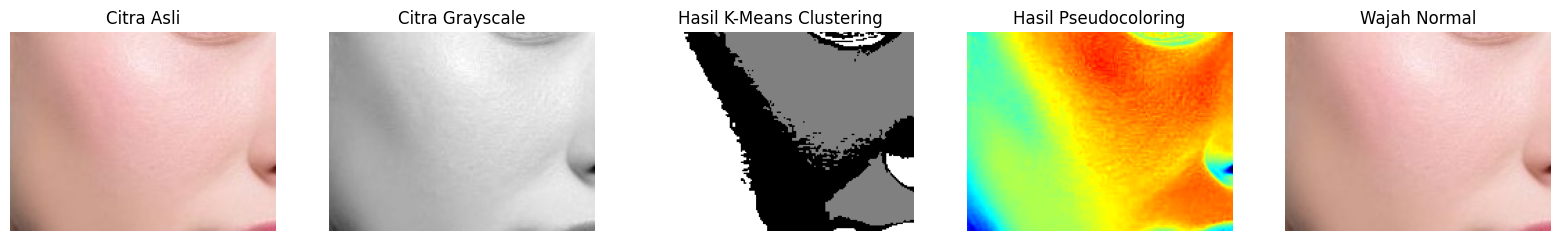

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

# Fungsi untuk memuat gambar sesuai dengan ekstensi file
def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"File tidak ditemukan: {image_path}")

    valid_extensions = ['.jpg', '.jpeg', '.png', 'webp']
    ext = os.path.splitext(image_path)[-1].lower()

    if ext not in valid_extensions:
        raise ValueError("Format file tidak didukung. Harap gunakan file dengan ekstensi .jpg, .jpeg, .png, atau .webp.")

    image = Image.open(image_path)
    return image

# Fungsi untuk mengonversi gambar ke grayscale
def convert_to_grayscale(image_np):
    if image_np.shape[2] != 3:
        raise ValueError("Gambar bukan format RGB")
    gray_image = 0.2989 * image_np[:, :, 0] + 0.5870 * image_np[:, :, 1] + 0.1140 * image_np[:, :, 2]
    return gray_image

def apply_pseudocolor(gray_image):
    # Pastikan bahwa gambar grayscale dalam rentang 0-255
    if gray_image.dtype != np.uint8:
        gray_image = ((gray_image - gray_image.min()) / (gray_image.max() - gray_image.min()) * 255).astype(np.uint8)

    pseudocolor_image = np.zeros((gray_image.shape[0], gray_image.shape[1], 3), dtype=np.uint8)

    for i in range(256):
        if i < 64:
            pseudocolor_image[gray_image == i] = [0, 0, int(255 * (i / 64))]  # Biru
        elif i < 128:
            pseudocolor_image[gray_image == i] = [0, int(255 * ((i - 64) / 64)), 255]  # Cyan
        elif i < 192:
            pseudocolor_image[gray_image == i] = [int(255 * ((i - 128) / 64)), 255, int(255 - (255 * ((i - 128) / 64)))]  # Kuning
        else:
            pseudocolor_image[gray_image == i] = [255, int(255 - (255 * ((i - 192) / 64))), 0]  # Merah

    return pseudocolor_image

# Kelas untuk K-Means
class KMeans:
    def __init__(self, k, seed=None):
        self.k = k
        self.seed = seed

    def train(self, X, MAXITER=100, TOL=1e-3):
        if self.seed is not None:
            np.random.seed(self.seed)
        centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]
        centroids_old = centroids.copy()
        for iter_ in range(MAXITER):
            dist = np.linalg.norm(X - centroids[0, :], axis=1).reshape(-1, 1)
            for class_ in range(1, self.k):
                dist = np.append(dist, np.linalg.norm(X - centroids[class_, :], axis=1).reshape(-1, 1), axis=1)
            classes = np.argmin(dist, axis=1)
            for class_ in set(classes):
                centroids[class_, :] = np.mean(X[classes == class_, :], axis=0)
            if np.linalg.norm(centroids - centroids_old) < TOL:
                break
            centroids_old = centroids.copy()
        self.centroids = centroids

    def predict(self, X):
        dist = np.linalg.norm(X - self.centroids[0, :], axis=1).reshape(-1, 1)
        for class_ in range(1, self.k):
            dist = np.append(dist, np.linalg.norm(X - self.centroids[class_, :], axis=1).reshape(-1, 1), axis=1)
        classes = np.argmin(dist, axis=1)
        return classes

# Fungsi untuk melakukan clustering dengan K-Means
def perform_kmeans(gray_image, k, seed):
    pixels = gray_image.reshape(-1, 1)
    kmeans = KMeans(k, seed=seed)
    kmeans.train(pixels)
    classes = kmeans.predict(pixels)
    clustered_image = classes.reshape(gray_image.shape)
    return clustered_image, kmeans.centroids

# Fungsi untuk menampilkan gambar
def display_images(original, grayscale, clustered, pseudocolor, result, result_title, edges_processed):
    plt.figure(figsize=(24, 10))

    plt.subplot(1, 6, 1)
    plt.imshow(original)
    plt.axis('off')
    plt.title('Citra Asli')

    plt.subplot(1, 6, 2)
    plt.imshow(grayscale, cmap='gray')
    plt.axis('off')
    plt.title('Citra Grayscale')

    plt.subplot(1, 6, 3)
    plt.imshow(clustered, cmap='gray')
    plt.axis('off')
    plt.title('Hasil K-Means Clustering')

    plt.subplot(1, 6, 4)
    plt.imshow(pseudocolor)
    plt.axis('off')
    plt.title('Hasil Pseudocoloring')

    plt.subplot(1, 6, 5)
    plt.imshow(result)
    plt.axis('off')
    plt.title(result_title)

    plt.show()

def determine_result(image_np, clustered_image, kmeans_centroids):
    unique, counts = np.unique(clustered_image, return_counts=True)
    cluster_frequencies = dict(zip(unique, counts))
    dominant_cluster = max(cluster_frequencies, key=cluster_frequencies.get)

    if dominant_cluster == 1:
        result_title = 'Wajah Normal'
        result_image = image_np
        edges_processed = np.zeros_like(image_np[:, :, 0])  # Placeholder untuk hasil morfologi
    else:
        acne_cluster = np.argmin(kmeans_centroids)
        acne_mask = (clustered_image == acne_cluster).astype(np.uint8)
        result_title = 'Wajah Berjerawat'
        result_image = image_np.copy()
        result_image[acne_mask == 1] = [255, 0, 0]  # Mengubah piksel berjerawat menjadi warna merah

        # Deteksi tepi Sobel secara manual pada area berjerawat
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

        edges_x = np.abs(np.convolve(result_image[:, :, 0].flatten(), sobel_x.flatten(), mode='same')).reshape(result_image[:, :, 0].shape)
        edges_y = np.abs(np.convolve(result_image[:, :, 0].flatten(), sobel_y.flatten(), mode='same')).reshape(result_image[:, :, 0].shape)

        edges = edges_x + edges_y
        edges[edges > 255] = 255  # Memastikan nilai maksimal adalah 255
        edges_processed = (edges.astype(np.uint8))

        # Menggabungkan tepi dengan gambar asli
        edges = edges.astype(np.uint8)
        result_image[acne_mask == 1] = [255, 0, 0]  # Mengembalikan warna merah untuk area berjerawat
        result_image[:, :, 0][acne_mask == 1] = edges[acne_mask == 1]  # Menggabungkan tepi dengan area berjerawat

        # Menambahkan kontur pada hasil deteksi tepi Sobel
        contours, _ = cv2.findContours(edges_processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(result_image, contours, -1, (0, 255, 0), 2)  # Kontur berwarna hijau

        # Identifikasi tingkat keparahan jerawat berdasarkan jumlah kontur
        num_contours = len(contours)
        if num_contours >= 1 and num_contours <= 4:
            result_title = 'Wajah Berjerawat Ringan'
            print("Jumlah kontur yang berhasil dideteksi = " + str(len(contours)))
        elif num_contours > 4 and num_contours <= 10:
            result_title = 'Wajah Berjerawat Sedang'
            print("Jumlah kontur yang berhasil dideteksi = " + str(len(contours)))
        else:
            result_title = 'Wajah Berjerawat Parah'
            print("Jumlah kontur yang berhasil dideteksi = " + str(len(contours)))

    return result_image, result_title, edges_processed


# Menyesuaikan dengan path image
image_path = 'WajahNormal1.jpg'

# Main execution
image = load_image(image_path)
image_np = np.array(image)
gray_image = convert_to_grayscale(image_np)
clustered_image, kmeans_centroids = perform_kmeans(gray_image, k=3, seed=42)
pseudocolor_image = apply_pseudocolor(gray_image)
result_image, result_title, edges_processed = determine_result(image_np, clustered_image, kmeans_centroids)
display_images(image, gray_image, clustered_image, pseudocolor_image, result_image, result_title, edges_processed)